In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

#Load CSV - by importing the CSV into a pandas DataFrame
df=pd.read_csv('inventory_forecasting.csv')

#Preview df
df.head()

c:\MY FILES\Coding\SQL\proj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0096,Toys,West,158,134,142,152.36,40.88,5,Sunny,1,42.39,Winter
1,2022-01-01,S001,P0016,Clothing,East,189,127,125,150.47,90.78,0,Rainy,0,84.16,Winter
2,2022-01-01,S001,P0031,Electronics,West,75,48,39,68.62,13.99,20,Rainy,0,12.67,Winter
3,2022-01-01,S001,P0159,Electronics,West,161,74,71,75.46,84.92,10,Snowy,0,83.03,Winter
4,2022-01-01,S001,P0129,Furniture,South,135,66,69,67.18,19.66,0,Cloudy,0,20.55,Winter


In [2]:
#To check for null values
df.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [3]:
#Rename columns to SQL-friendly format
df.columns=[c.strip().replace(' ','_').replace('/','_') for c in df.columns]

df.columns

Index(['Date', 'Store_ID', 'Product_ID', 'Category', 'Region',
       'Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Demand_Forecast',
       'Price', 'Discount', 'Weather_Condition', 'Holiday_Promotion',
       'Competitor_Pricing', 'Seasonality'],
      dtype='object')

In [4]:
#Create in-memory SQLite DB
conn=sqlite3.connect('retail.db')

#Write table to SQLite, named 'InventoryData'
df.to_sql('InventoryData',conn,if_exists='replace',index=False)

109500

In [5]:
gquery_1="""
SELECT distinct Category FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

,Category
0,Toys
1,Clothing
2,Electronics
3,Furniture
4,Groceries


In [6]:
gquery_1="""
SELECT DISTINCT Category,Product_ID
FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

,Category,Product_ID
0,Toys,P0096
1,Clothing,P0016
2,Electronics,P0031
3,Electronics,P0159
4,Furniture,P0129
5,Furniture,P0116
6,Electronics,P0070
7,Electronics,P0171
8,Electronics,P0175
9,Clothing,P0046


In [7]:

gquery_2 = """
SELECT 
    Store_ID,

    -- Electronics KPIs
    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Inventory_Level ELSE 0 END), 0) AS Electronics_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Electronics' THEN Inventory_Level ELSE 0 END), 0) AS Electronics_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END), 0) AS Electronics_Order_Sales_Ratio,

    -- Grocery KPIs
    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Inventory_Level ELSE 0 END), 0) AS Grocery_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Groceries' THEN Inventory_Level ELSE 0 END), 0) AS Grocery_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END), 0) AS Grocery_Order_Sales_Ratio,

    -- Clothing KPIs
    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Inventory_Level ELSE 0 END), 0) AS Clothing_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Clothing' THEN Inventory_Level ELSE 0 END), 0) AS Clothing_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END), 0) AS Clothing_Order_Sales_Ratio,

    -- Furniture KPIs
    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Inventory_Level ELSE 0 END), 0) AS Furniture_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Furniture' THEN Inventory_Level ELSE 0 END), 0) AS Furniture_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END), 0) AS Furniture_Order_Sales_Ratio,

        -- Toys KPIs
    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Inventory_Level ELSE 0 END), 0) AS Toys_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Toys' THEN Inventory_Level ELSE 0 END), 0) AS Toys_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END), 0) AS Toys_Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID;
"""

df_kpi_by_store = pd.read_sql_query(gquery_2, conn)
df_kpi_by_store.describe()

,Electronics_Sell_Through_Rate,Electronics_Inventory_Turnover,Electronics_Order_Sales_Ratio,Grocery_Sell_Through_Rate,Grocery_Inventory_Turnover,Grocery_Order_Sales_Ratio,Clothing_Sell_Through_Rate,Clothing_Inventory_Turnover,Clothing_Order_Sales_Ratio,Furniture_Sell_Through_Rate,Furniture_Inventory_Turnover,Furniture_Order_Sales_Ratio,Toys_Sell_Through_Rate,Toys_Inventory_Turnover,Toys_Order_Sales_Ratio
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.643242,14086.997461,0.993837,0.671436,14704.458140,0.995051,0.681740,14930.111446,0.997181,0.655876,14363.676230,0.994819,0.656019,14366.809837,0.995834
std,0.001572,34.431355,0.001427,0.005520,120.897629,0.001941,0.000922,20.192154,0.001563,0.003346,73.272254,0.001984,0.004465,97.794103,0.002952
min,0.640984,14037.550535,0.991675,0.665845,14582.011837,0.992473,0.680320,14899.008413,0.995836,0.650973,14256.317924,0.991541,0.651030,14257.555424,0.992026
25%,0.642635,14073.706275,0.993211,0.666414,14594.462374,0.993477,0.681313,14920.757799,0.996307,0.655193,14348.723071,0.994944,0.651230,14261.939521,0.994189
50%,0.643149,14084.972166,0.994203,0.670816,14690.877612,0.996116,0.682166,14939.441085,0.996715,0.655276,14350.543654,0.995055,0.659125,14434.845250,0.995739
75%,0.644579,14116.283401,0.994957,0.676072,14805.966058,0.996436,0.682382,14944.172573,0.997225,0.658338,14417.598233,0.995700,0.659208,14436.647102,0.997545
max,0.644862,14122.474926,0.995139,0.678035,14848.972820,0.996752,0.682520,14947.177362,0.999823,0.659598,14445.198270,0.996854,0.659501,14443.061889,0.999670


In [8]:
gquery_3 = """
SELECT 
    Store_ID,
    Product_ID,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(SUM(Inventory_Level), 0) AS Sell_Through_Rate,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(AVG(Inventory_Level), 0) AS Inventory_Turnover,

    SUM(Units_Ordered) * 1.0 / 
    NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID, Product_ID;
"""
df_kpi_by_product = pd.read_sql_query(gquery_3, conn)
df_kpi_by_product.describe()


,Sell_Through_Rate,Inventory_Turnover,Order_Sales_Ratio
count,150.000000,150.000000,150.000000
mean,0.663062,484.035517,0.995532
std,0.017167,12.532216,0.004898
min,0.630336,460.145460,0.982593
25%,0.648485,473.393798,0.992798
50%,0.661748,483.076100,0.995296
75%,0.679095,495.739337,0.998287
max,0.695294,507.564283,1.008378


In [9]:
gquery_4 = """
SELECT *
FROM (
    SELECT 
        Store_ID,
        Product_ID,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(SUM(Inventory_Level), 0) AS Sell_Through_Rate,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(AVG(Inventory_Level), 0) AS Inventory_Turnover,

        SUM(Units_Ordered) * 1.0 / 
        NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

    FROM InventoryData
    GROUP BY Store_ID, Product_ID
) AS sub
WHERE Order_Sales_Ratio > 1.02 OR Order_Sales_Ratio < 0.98;
"""

df_kpi_anom_2per = pd.read_sql_query(gquery_4, conn)
df_kpi_anom_2per


,Store_ID,Product_ID,Sell_Through_Rate,Inventory_Turnover,Order_Sales_Ratio


In [10]:
#Current Stock per Product per Store
query1_storewise = """
SELECT Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Date = (SELECT MAX(Date) FROM InventoryData)
ORDER BY Product_ID, Store_ID;
"""
pd.read_sql_query(query1_storewise, conn)

,Product_ID,Store_ID,Inventory_Level
0,P0016,S001,111
1,P0016,S002,277
2,P0016,S003,228
3,P0016,S004,248
4,P0016,S005,240
...,...,...,...
145,P0187,S001,245
146,P0187,S002,115
147,P0187,S003,193
148,P0187,S004,130


In [11]:
#Low Inventory Detection, triggering a restock alert
query2= """
SELECT Date, Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Inventory_Level < Demand_Forecast
ORDER BY Date;
"""
pd.read_sql_query(query2, conn)

,Date,Product_ID,Store_ID,Inventory_Level
0,2022-01-01,P0116,S001,53
1,2022-01-01,P0067,S001,101
2,2022-01-01,P0017,S001,70
3,2022-01-01,P0016,S002,210
4,2022-01-01,P0129,S002,87
...,...,...,...,...
16267,2023-12-31,P0126,S004,67
16268,2023-12-31,P0171,S005,139
16269,2023-12-31,P0187,S005,195
16270,2023-12-31,P0153,S005,87


In [12]:
#7-Day Rolling Average
#Approximates product demand
query3="""
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_7Day_Sales
FROM InventoryData
WHERE Date>=(
   SELECT DATE(MAX(Date), '-6 day')
   FROM InventoryData
)
GROUP BY Product_ID
ORDER BY Avg_7Day_Sales DESC;
"""
pd.read_sql_query(query3, conn)

,Product_ID,Avg_7Day_Sales
0,P0016,135.89
1,P0133,133.94
2,P0187,133.60
3,P0125,132.31
4,P0057,132.17
5,P0061,127.77
6,P0126,127.74
7,P0066,127.51
8,P0178,123.03
9,P0046,121.80


In [13]:
#Inventory Turnover
#High turnover=fast-moving product, constantlu restocking
query4="""
SELECT Product_ID,
       SUM(Units_Sold) as Total_Sales,
       AVG(Inventory_Level) as Avg_Inventory,
       ROUND(SUM(Units_Sold)/AVG(Inventory_Level),2) AS Inventory_Turnover
FROM InventoryData
GROUP BY Product_ID
ORDER BY Inventory_Turnover DESC;
"""
pd.read_sql_query(query4, conn)

,Product_ID,Total_Sales,Avg_Inventory,Inventory_Turnover
0,P0046,386805,154.506301,2503.49
1,P0133,385843,154.356986,2499.68
2,P0057,387209,155.087945,2496.71
3,P0178,384440,153.986575,2496.58
4,P0187,385583,154.869315,2489.73
5,P0066,384764,154.667123,2487.69
6,P0125,385137,154.882192,2486.64
7,P0061,384668,154.775342,2485.33
8,P0069,382968,154.473151,2479.19
9,P0016,384509,155.221096,2477.17


In [14]:
#Ranks products by average daily sales volume
query5 = """
SELECT Product_ID,
       AVG(Units_Sold) AS Avg_Sales_Per_Day
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Sales_Per_Day DESC;
"""
pd.read_sql_query(query5, conn)

,Product_ID,Avg_Sales_Per_Day
0,P0057,106.084658
1,P0046,105.973973
2,P0133,105.710411
3,P0187,105.639178
4,P0125,105.516986
5,P0066,105.414795
6,P0061,105.388493
7,P0016,105.344932
8,P0178,105.326027
9,P0069,104.922740


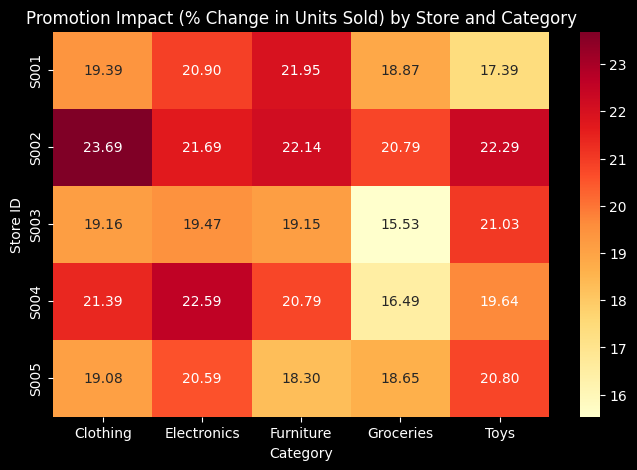

In [15]:
query6 = """
SELECT Store_ID,Category,
       AVG(Units_Sold) AS Avg_Units_Sold,
       100*(AVG(CASE WHEN Holiday_Promotion = 1 THEN units_sold END)-
       AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END))/ AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END) AS Percentage_Change_Between_Promotions
FROM InventoryData
GROUP BY Store_ID,Category 
ORDER BY Percentage_Change_Between_Promotions DESC;
"""
df_kpi_by_promotions = pd.read_sql_query(query6, conn)
df_kpi_by_promotions_cat = df_kpi_by_promotions.pivot(index='Store_ID', columns='Category', values='Percentage_Change_Between_Promotions')
plt.figure(figsize=(8, 5))
sns.heatmap(df_kpi_by_promotions_cat, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Promotion Impact (% Change in Units Sold) by Store and Category")
plt.ylabel("Store ID")
plt.xlabel("Category")
plt.show()

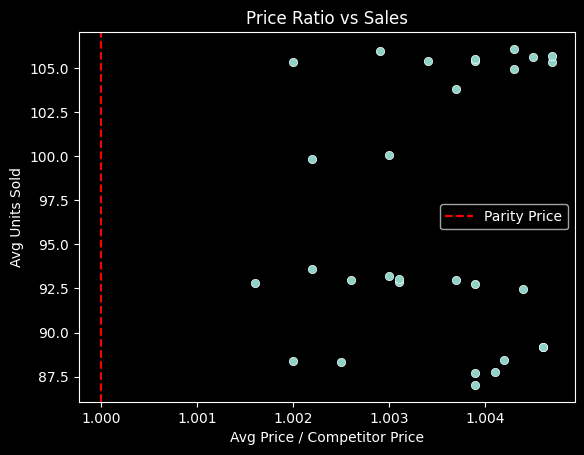

In [16]:
#Price Competitivness vs Sales
#Analyzes whether being cheaper correlates with more units solds
query7a= """
SELECT Product_ID,
       ROUND(AVG(Price / Competitor_Pricing), 4) AS Avg_Price_Ratio,
       AVG(Units_Sold) AS Avg_Units_Sold
FROM InventoryData
WHERE Competitor_Pricing > 0
GROUP BY Product_ID;
"""
df_price_effect = pd.read_sql_query(query7a, conn)

sns.scatterplot(data=df_price_effect, x='Avg_Price_Ratio', y='Avg_Units_Sold')
plt.axvline(1, color='red', linestyle='--', label='Parity Price')
plt.title('Price Ratio vs Sales')
plt.xlabel('Avg Price / Competitor Price')
plt.ylabel('Avg Units Sold')
plt.legend()
plt.show()

All products are priced above competitor levels.This may explain suboptimal sales performance for some SKUs.We reccomend dynamic pricing analysis.

In [17]:
#Price Bucket Breakdown
query7b = """
WITH ProductRatios AS (
  SELECT 
    Product_ID,
    ROUND(AVG(Price / Competitor_Pricing), 2) AS Avg_Price_Ratio,
    AVG(Units_Sold) AS Avg_Units_Sold
  FROM InventoryData
  WHERE Competitor_Pricing > 0
  GROUP BY Product_ID
)

SELECT
  CASE 
    WHEN Avg_Price_Ratio BETWEEN 1.00 AND 1.05 THEN '🟢 Slightly Higher (≤5%)'
    WHEN Avg_Price_Ratio BETWEEN 1.05 AND 1.20 THEN '🟡 Moderately Higher (5–20%)'
    ELSE '🔴 Significantly Higher (>20%)'
  END AS Price_Positioning,

  COUNT(*) AS Num_Products,
  ROUND(AVG(Avg_Units_Sold), 2) AS Avg_Units_Sold

FROM ProductRatios
GROUP BY Price_Positioning
ORDER BY Price_Positioning;
"""

pd.read_sql_query(query7b, conn)

,Price_Positioning,Num_Products,Avg_Units_Sold
0,🟢 Slightly Higher (≤5%),30,96.72


In [18]:
#Forecast Accuracy
query8 = """
SELECT Product_ID,
       100*ROUND(AVG(ABS(Units_Sold - Demand_Forecast)/Units_Sold), 4) AS Avg_Forecast_Error
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Forecast_Error DESC;
"""
pd.read_sql_query(query8, conn)

,Product_ID,Avg_Forecast_Error
0,P0079,16.15
1,P0031,16.13
2,P0085,16.09
3,P0187,16.08
4,P0183,15.99
5,P0094,15.95
6,P0046,15.95
7,P0069,15.94
8,P0017,15.93
9,P0149,15.90




**Python** **Forecasting**


Import libraries needed for forecasting

We’ll use Prophet for time series, Random Forest for machine learning, and pandas for data handling.

In [19]:
# Load data for top 5 products from SQLite 
#to build the forecasting pipeline
query_top_products = """
SELECT Product_ID, SUM(Units_Sold) AS Total_Units
FROM InventoryData
GROUP BY Product_ID
ORDER BY Total_Units DESC
LIMIT 5;
"""

top_products = pd.read_sql_query(query_top_products, conn)['Product_ID'].tolist()
top_products

['P0057', 'P0046', 'P0133', 'P0187', 'P0125']

In [20]:
def forecast_for_product(product_id, conn):
    # 1. Load data
    query = f"""
    SELECT Date, Product_ID, Units_Sold, Demand_Forecast, Price, Competitor_Pricing,
           Discount, Holiday_Promotion, Inventory_Level
    FROM InventoryData
    WHERE Product_ID = '{product_id}'
    ORDER BY Date;
    """
    df = pd.read_sql_query(query, conn)
    if len(df) < 30:
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # 2. Feature engineering
    df['Lag_1'] = df['Units_Sold'].shift(1)
    df['Lag_7'] = df['Units_Sold'].shift(7)
    df['Rolling_7'] = df['Units_Sold'].rolling(7).mean()
    df['Price_Ratio'] = df['Price'] / df['Competitor_Pricing']
    df['Promo_Flag'] = (df['Holiday_Promotion'] == 'Yes').astype(int)
    df = df.dropna()

    if df.shape[0] < 21:
        return None

    # 3. Train Random Forest model
    features = ['Lag_1', 'Lag_7', 'Rolling_7', 'Price_Ratio', 'Promo_Flag']
    X = df[features]
    y = df['Units_Sold']
    X_train, X_test = X[:-14], X[-14:]
    y_train = y[:-14]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # 4. Prophet model(Time-Series)
    df_prophet = df[['Date', 'Units_Sold']].rename(columns={'Date': 'ds', 'Units_Sold': 'y'})
    prophet_model = Prophet()
    prophet_model.fit(df_prophet)
    future = prophet_model.make_future_dataframe(periods=14)
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].tail(14).reset_index(drop=True)

    # 5. Blend
    blended_df = df[['Date']].iloc[-14:].reset_index(drop=True)
    blended_df['RF_Pred'] = rf_pred
    blended_df['Prophet_Pred'] = prophet_pred['yhat']
    blended_df['Blended_Forecast'] = 0.7 * rf_pred + 0.3 * prophet_pred['yhat']
    blended_df['Date'] = prophet_pred['ds']
    blended_df['Product_ID'] = product_id

    # 6. Reorder logic
    blended_df['Safety_Stock'] = 0.1 * blended_df['Blended_Forecast'] #buffer
    blended_df['Required_Inventory'] = blended_df['Blended_Forecast'] + blended_df['Safety_Stock']
    current_inventory = df['Inventory_Level'].iloc[-1]
    blended_df['Reorder_Qty'] = (blended_df['Required_Inventory'] - current_inventory).clip(lower=0).round()

    return blended_df[['Product_ID', 'Date', 'Blended_Forecast', 'Reorder_Qty']]


Forecast Function

Reusable forecasting logic for each product: SQL → Features → ML + Prophet → Reorder


In [21]:
#Loop over top 5 products
#calculate the Reorder quantity
all_forecasts = []

for pid in top_products:
    print(f"Processing {pid}...")
    result = forecast_for_product(pid, conn)
    if result is not None:
        all_forecasts.append(result)

forecast_results = pd.concat(all_forecasts, ignore_index=True)
forecast_results.head()

Processing P0057...


10:38:08 - cmdstanpy - INFO - Chain [1] start processing
10:38:08 - cmdstanpy - INFO - Chain [1] done processing
10:38:08 - cmdstanpy - INFO - Chain [1] done processing


Processing P0046...


10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:10 - cmdstanpy - INFO - Chain [1] done processing
10:38:10 - cmdstanpy - INFO - Chain [1] done processing


Processing P0133...


10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing


Processing P0187...


10:38:13 - cmdstanpy - INFO - Chain [1] start processing
10:38:13 - cmdstanpy - INFO - Chain [1] done processing
10:38:13 - cmdstanpy - INFO - Chain [1] done processing


Processing P0125...


10:38:14 - cmdstanpy - INFO - Chain [1] start processing
10:38:15 - cmdstanpy - INFO - Chain [1] done processing
10:38:15 - cmdstanpy - INFO - Chain [1] done processing


,Product_ID,Date,Blended_Forecast,Reorder_Qty
0,P0057,2024-01-01,141.436735,29.0
1,P0057,2024-01-02,136.191824,23.0
2,P0057,2024-01-03,133.790452,20.0
3,P0057,2024-01-04,135.402552,22.0
4,P0057,2024-01-05,141.922621,29.0


# 📊 COMPREHENSIVE QUERY RESULTS & VISUALIZATIONS

This section contains all SQL queries saved in properly named dataframes with relevant visualizations for business insights.

📋 Categories in Dataset:
      Category
0         Toys
1     Clothing
2  Electronics
3    Furniture
4    Groceries

📊 Total Category-Product Combinations: 30


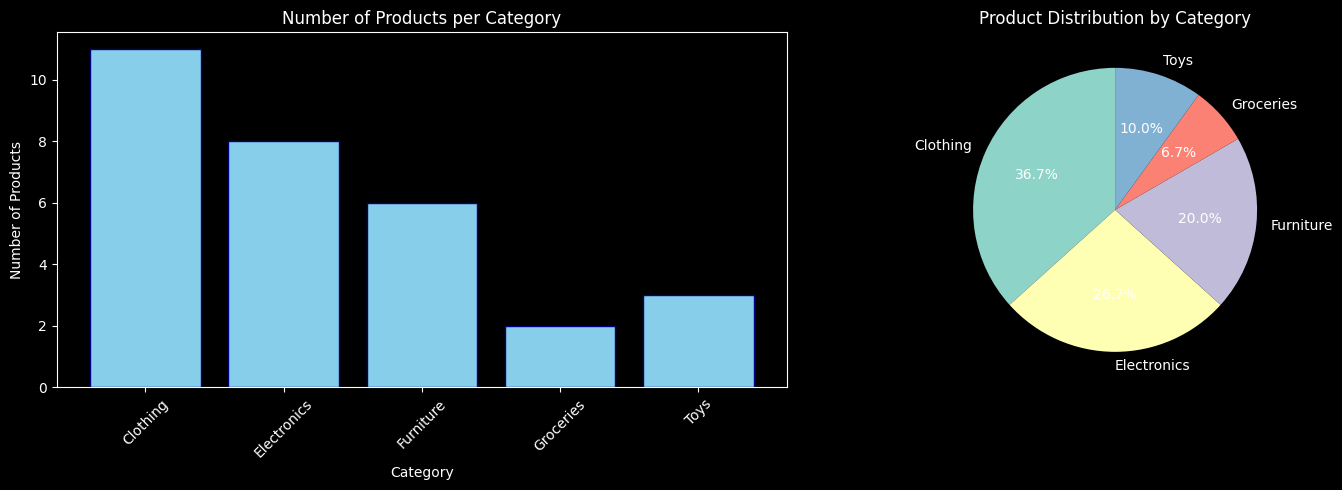

In [22]:
# =====================================
# 1. BASIC DATA EXPLORATION QUERIES
# =====================================

# Query 1A: Distinct Categories
df_distinct_categories = pd.read_sql_query("""
SELECT DISTINCT Category FROM InventoryData
""", conn)

# Query 1B: Distinct Category-Product combinations
df_category_products = pd.read_sql_query("""
SELECT DISTINCT Category, Product_ID
FROM InventoryData
ORDER BY Category, Product_ID
""", conn)

print("📋 Categories in Dataset:")
print(df_distinct_categories)
print(f"\n📊 Total Category-Product Combinations: {len(df_category_products)}")

# Visualization: Product count by category
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Chart 1: Products per category
category_counts = df_category_products.groupby('Category').size()
ax1.bar(category_counts.index, category_counts.values, color='skyblue', edgecolor='navy')
ax1.set_title('Number of Products per Category')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Products')
ax1.tick_params(axis='x', rotation=45)

# Chart 2: Pie chart of category distribution
ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Product Distribution by Category')

plt.tight_layout()
plt.show()

✅ Store KPIs by Category: df_kpi_by_store
Shape: (5, 16)
✅ Product KPIs: df_kpi_by_product
Shape: (150, 5)
✅ Anomalous Products (>2% deviation): df_kpi_anom_2per
Shape: (0, 5)


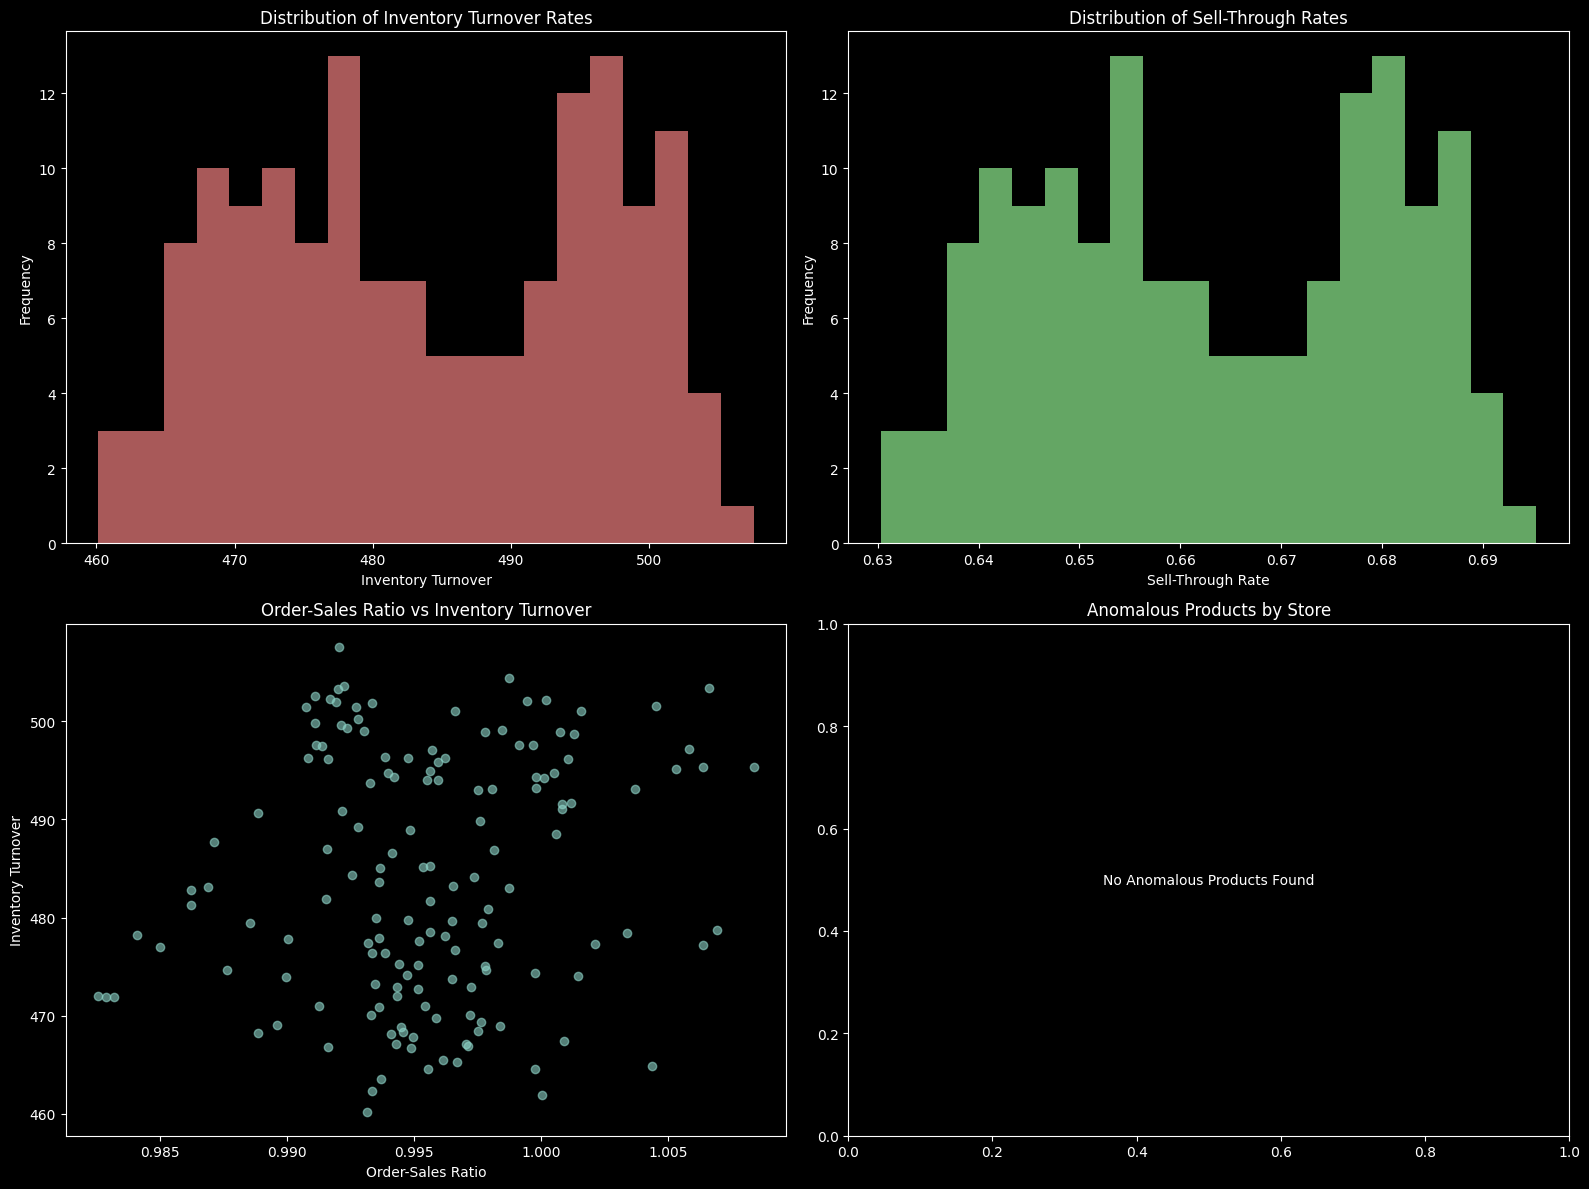

In [23]:
# =====================================
# 2. KPI ANALYSIS QUERIES
# =====================================

# Query 2A: Store-level KPIs by Category (already exists as df_kpi_by_store)
print("✅ Store KPIs by Category: df_kpi_by_store")
print(f"Shape: {df_kpi_by_store.shape}")

# Query 2B: Product-level KPIs (already exists as df_kpi_by_product)  
print("✅ Product KPIs: df_kpi_by_product")
print(f"Shape: {df_kpi_by_product.shape}")

# Query 2C: Anomalous Order-Sales Ratios (already exists as df_kpi_anom_2per)
print("✅ Anomalous Products (>2% deviation): df_kpi_anom_2per")
print(f"Shape: {df_kpi_anom_2per.shape}")

# Additional KPI Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Inventory Turnover Distribution
axes[0,0].hist(df_kpi_by_product['Inventory_Turnover'].dropna(), bins=20, color='lightcoral', alpha=0.7)
axes[0,0].set_title('Distribution of Inventory Turnover Rates')
axes[0,0].set_xlabel('Inventory Turnover')
axes[0,0].set_ylabel('Frequency')

# Chart 2: Sell-Through Rate Distribution
axes[0,1].hist(df_kpi_by_product['Sell_Through_Rate'].dropna(), bins=20, color='lightgreen', alpha=0.7)
axes[0,1].set_title('Distribution of Sell-Through Rates')
axes[0,1].set_xlabel('Sell-Through Rate')
axes[0,1].set_ylabel('Frequency')

# Chart 3: Order-Sales Ratio vs Inventory Turnover
scatter_data = df_kpi_by_product.dropna()
axes[1,0].scatter(scatter_data['Order_Sales_Ratio'], scatter_data['Inventory_Turnover'], alpha=0.6)
axes[1,0].set_title('Order-Sales Ratio vs Inventory Turnover')
axes[1,0].set_xlabel('Order-Sales Ratio')
axes[1,0].set_ylabel('Inventory Turnover')

# Chart 4: Anomalous products by store
if len(df_kpi_anom_2per) > 0:
    anom_by_store = df_kpi_anom_2per.groupby('Store_ID').size()
    axes[1,1].bar(anom_by_store.index, anom_by_store.values, color='orange')
    axes[1,1].set_title('Anomalous Products by Store')
    axes[1,1].set_xlabel('Store ID')
    axes[1,1].set_ylabel('Number of Anomalous Products')
else:
    axes[1,1].text(0.5, 0.5, 'No Anomalous Products Found', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Anomalous Products by Store')

plt.tight_layout()
plt.show()

📦 Current Stock Levels: 150 records
🚨 Low Inventory Alerts: 16272 alerts
📈 7-Day Rolling Sales: 30 products
🔄 Inventory Turnover: 30 products
📊 Daily Sales Stats: 30 products


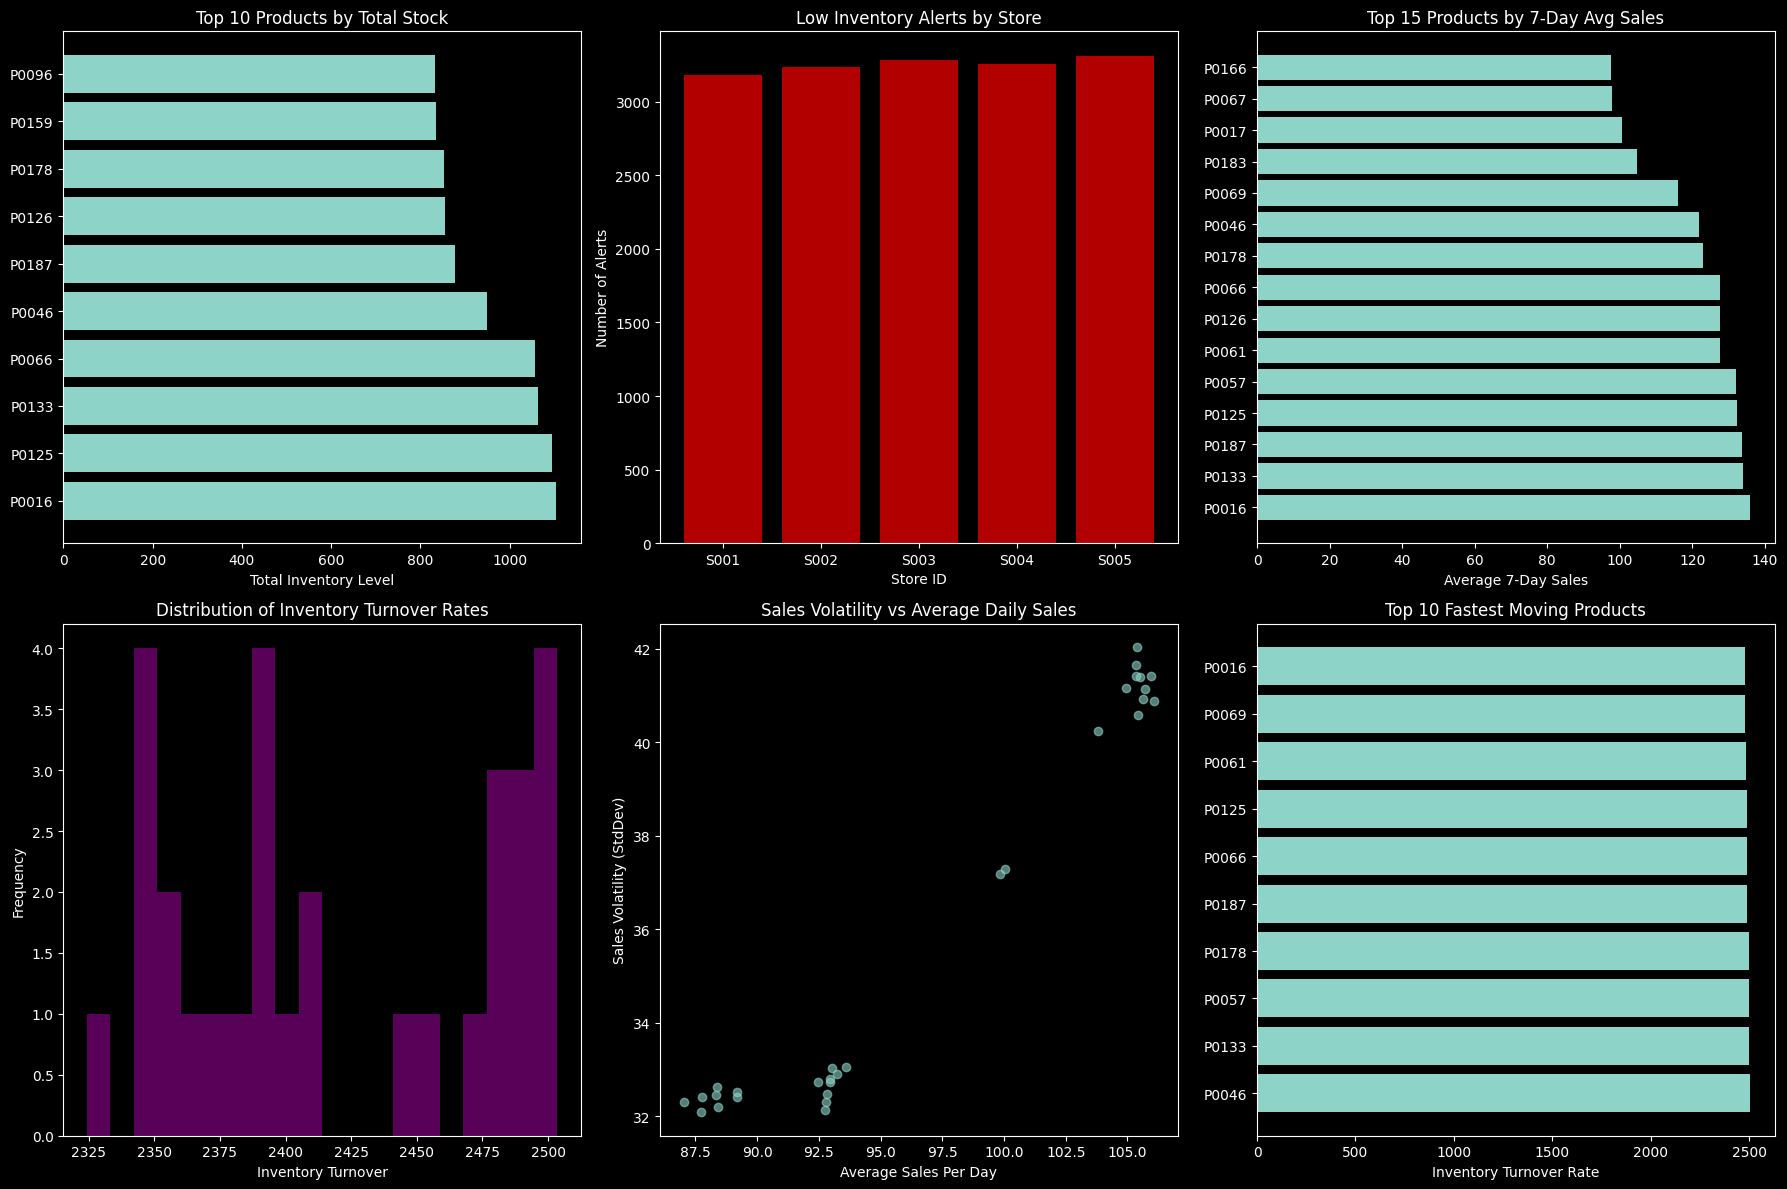

In [24]:
# =====================================
# 3. INVENTORY MANAGEMENT QUERIES
# =====================================

# Query 3A: Current Stock Levels by Store and Product
df_current_stock = pd.read_sql_query("""
SELECT Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Date = (SELECT MAX(Date) FROM InventoryData)
ORDER BY Product_ID, Store_ID;
""", conn)

# Query 3B: Low Inventory Alerts 
df_low_inventory_alerts = pd.read_sql_query("""
SELECT Date, Product_ID, Store_ID, Inventory_Level, Demand_Forecast,
       (Demand_Forecast - Inventory_Level) AS Shortage_Amount
FROM InventoryData
WHERE Inventory_Level < Demand_Forecast
ORDER BY Date, Shortage_Amount DESC;
""", conn)

# Query 3C: 7-Day Rolling Sales Average
df_rolling_sales_7day = pd.read_sql_query("""
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_7Day_Sales,
       COUNT(*) AS Days_In_Period
FROM InventoryData
WHERE Date >= (
   SELECT DATE(MAX(Date), '-6 day')
   FROM InventoryData
)
GROUP BY Product_ID
ORDER BY Avg_7Day_Sales DESC;
""", conn)

# Query 3D: Inventory Turnover Analysis
df_inventory_turnover = pd.read_sql_query("""
SELECT Product_ID,
       SUM(Units_Sold) as Total_Sales,
       AVG(Inventory_Level) as Avg_Inventory,
       ROUND(SUM(Units_Sold)/AVG(Inventory_Level),2) AS Inventory_Turnover,
       COUNT(DISTINCT Date) AS Days_Tracked
FROM InventoryData
GROUP BY Product_ID
ORDER BY Inventory_Turnover DESC;
""", conn)

# Query 3E: Average Daily Sales Volume by Product
df_avg_daily_sales = pd.read_sql_query("""
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_Sales_Per_Day,
       MIN(Units_Sold) AS Min_Daily_Sales,
       MAX(Units_Sold) AS Max_Daily_Sales,
       COUNT(*) AS Total_Days
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Sales_Per_Day DESC;
""", conn)

# Calculate sales volatility using pandas
df_volatility = pd.read_sql_query("""
SELECT Product_ID, Units_Sold 
FROM InventoryData
""", conn).groupby('Product_ID')['Units_Sold'].std().reset_index()
df_volatility.columns = ['Product_ID', 'Sales_Volatility']
df_volatility['Sales_Volatility'] = df_volatility['Sales_Volatility'].round(2)

# Merge volatility with main dataframe
df_avg_daily_sales = df_avg_daily_sales.merge(df_volatility, on='Product_ID', how='left')

print(f"📦 Current Stock Levels: {len(df_current_stock)} records")
print(f"🚨 Low Inventory Alerts: {len(df_low_inventory_alerts)} alerts")
print(f"📈 7-Day Rolling Sales: {len(df_rolling_sales_7day)} products")
print(f"🔄 Inventory Turnover: {len(df_inventory_turnover)} products")
print(f"📊 Daily Sales Stats: {len(df_avg_daily_sales)} products")

# Inventory Management Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: Top 10 products by current stock
top_stock = df_current_stock.groupby('Product_ID')['Inventory_Level'].sum().nlargest(10)
axes[0,0].barh(range(len(top_stock)), top_stock.values)
axes[0,0].set_yticks(range(len(top_stock)))
axes[0,0].set_yticklabels(top_stock.index)
axes[0,0].set_title('Top 10 Products by Total Stock')
axes[0,0].set_xlabel('Total Inventory Level')

# Chart 2: Low inventory distribution by store
if len(df_low_inventory_alerts) > 0:
    low_inv_by_store = df_low_inventory_alerts.groupby('Store_ID').size()
    axes[0,1].bar(low_inv_by_store.index, low_inv_by_store.values, color='red', alpha=0.7)
    axes[0,1].set_title('Low Inventory Alerts by Store')
    axes[0,1].set_xlabel('Store ID')
    axes[0,1].set_ylabel('Number of Alerts')
else:
    axes[0,1].text(0.5, 0.5, 'No Low Inventory Alerts', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Low Inventory Alerts by Store')

# Chart 3: Top 15 products by 7-day rolling sales
top_rolling = df_rolling_sales_7day.head(15)
axes[0,2].barh(range(len(top_rolling)), top_rolling['Avg_7Day_Sales'])
axes[0,2].set_yticks(range(len(top_rolling)))
axes[0,2].set_yticklabels(top_rolling['Product_ID'])
axes[0,2].set_title('Top 15 Products by 7-Day Avg Sales')
axes[0,2].set_xlabel('Average 7-Day Sales')

# Chart 4: Inventory turnover distribution
axes[1,0].hist(df_inventory_turnover['Inventory_Turnover'].dropna(), bins=20, color='purple', alpha=0.7)
axes[1,0].set_title('Distribution of Inventory Turnover Rates')
axes[1,0].set_xlabel('Inventory Turnover')
axes[1,0].set_ylabel('Frequency')

# Chart 5: Sales volatility vs average sales
axes[1,1].scatter(df_avg_daily_sales['Avg_Sales_Per_Day'], df_avg_daily_sales['Sales_Volatility'], alpha=0.6)
axes[1,1].set_title('Sales Volatility vs Average Daily Sales')
axes[1,1].set_xlabel('Average Sales Per Day')
axes[1,1].set_ylabel('Sales Volatility (StdDev)')

# Chart 6: Top 10 fastest moving products
top_turnover = df_inventory_turnover.head(10)
axes[1,2].barh(range(len(top_turnover)), top_turnover['Inventory_Turnover'])
axes[1,2].set_yticks(range(len(top_turnover)))
axes[1,2].set_yticklabels(top_turnover['Product_ID'])
axes[1,2].set_title('Top 10 Fastest Moving Products')
axes[1,2].set_xlabel('Inventory Turnover Rate')

plt.tight_layout()
plt.show()

✅ Promotion Impact by Store & Category: df_kpi_by_promotions
Shape: (25, 4)
✅ Price Competitiveness vs Sales: df_price_effect
Shape: (30, 3)
💰 Price Positioning Analysis: 30 products
🎯 Promotion Performance Details: 150 product-store combinations


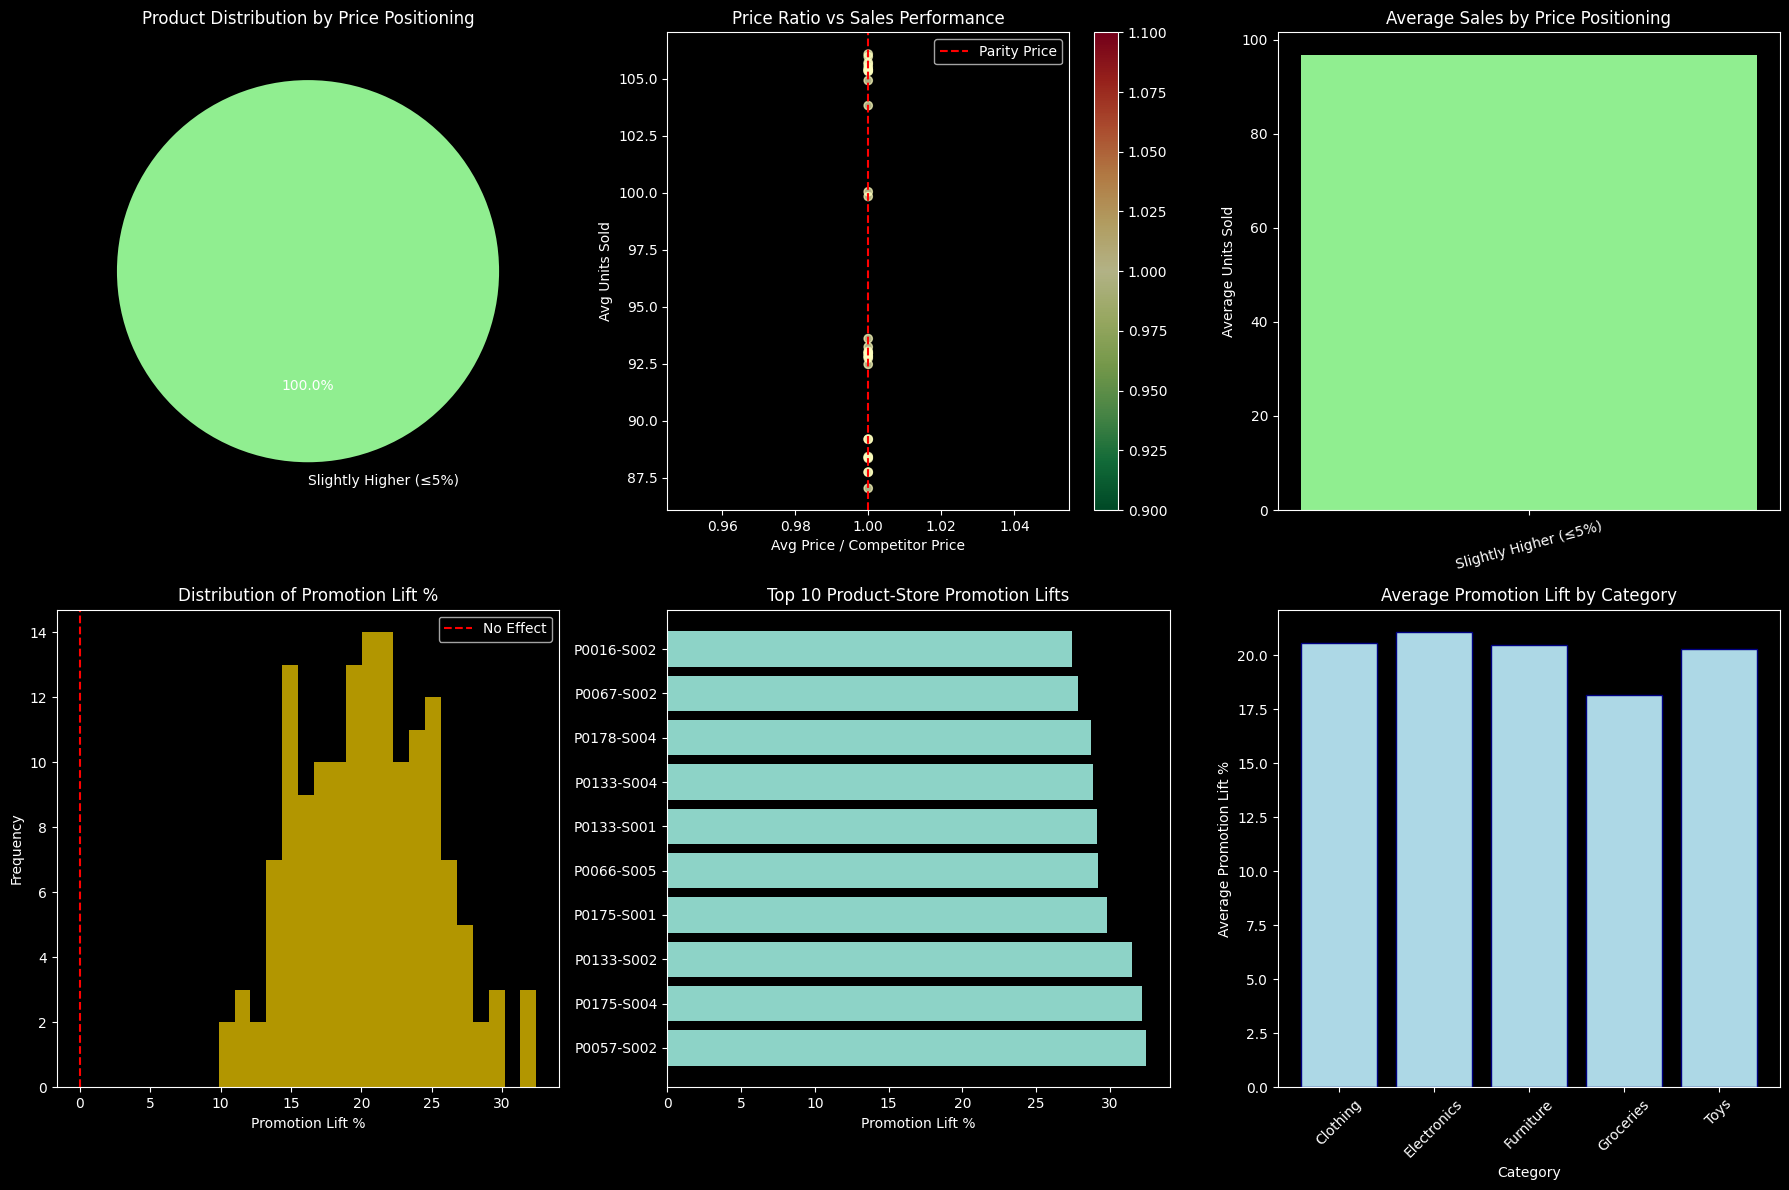

In [25]:
# =====================================
# 4. PRICING & PROMOTION ANALYSIS
# =====================================

# Query 4A: Promotion Impact Analysis (already exists as df_kpi_by_promotions)
print("✅ Promotion Impact by Store & Category: df_kpi_by_promotions")
print(f"Shape: {df_kpi_by_promotions.shape}")

# Query 4B: Price Competitiveness Analysis (already exists as df_price_effect)
print("✅ Price Competitiveness vs Sales: df_price_effect") 
print(f"Shape: {df_price_effect.shape}")

# Query 4C: Price Positioning Buckets
df_price_positioning = pd.read_sql_query("""
WITH ProductRatios AS (
  SELECT 
    Product_ID,
    ROUND(AVG(Price / Competitor_Pricing), 2) AS Avg_Price_Ratio,
    AVG(Units_Sold) AS Avg_Units_Sold,
    COUNT(*) AS Observation_Count
  FROM InventoryData
  WHERE Competitor_Pricing > 0
  GROUP BY Product_ID
)

SELECT
  Product_ID,
  Avg_Price_Ratio,
  Avg_Units_Sold,
  Observation_Count,
  CASE 
    WHEN Avg_Price_Ratio BETWEEN 1.00 AND 1.05 THEN 'Slightly Higher (≤5%)'
    WHEN Avg_Price_Ratio BETWEEN 1.05 AND 1.20 THEN 'Moderately Higher (5–20%)'
    ELSE 'Significantly Higher (>20%)'
  END AS Price_Positioning

FROM ProductRatios
ORDER BY Avg_Price_Ratio;
""", conn)

# Query 4D: Detailed Promotion Performance
df_promotion_details = pd.read_sql_query("""
SELECT 
    Product_ID,
    Category,
    Store_ID,
    AVG(CASE WHEN Holiday_Promotion = 1 THEN Units_Sold END) AS Promo_Avg_Sales,
    AVG(CASE WHEN Holiday_Promotion = 0 THEN Units_Sold END) AS Regular_Avg_Sales,
    COUNT(CASE WHEN Holiday_Promotion = 1 THEN 1 END) AS Promo_Days,
    COUNT(CASE WHEN Holiday_Promotion = 0 THEN 1 END) AS Regular_Days,
    100 * (AVG(CASE WHEN Holiday_Promotion = 1 THEN Units_Sold END) - 
           AVG(CASE WHEN Holiday_Promotion = 0 THEN Units_Sold END)) / 
           NULLIF(AVG(CASE WHEN Holiday_Promotion = 0 THEN Units_Sold END), 0) AS Promo_Lift_Percent
FROM InventoryData
GROUP BY Product_ID, Category, Store_ID
HAVING Promo_Days > 0 AND Regular_Days > 0
ORDER BY Promo_Lift_Percent DESC;
""", conn)

print(f"💰 Price Positioning Analysis: {len(df_price_positioning)} products")
print(f"🎯 Promotion Performance Details: {len(df_promotion_details)} product-store combinations")

# Pricing & Promotion Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: Price positioning distribution
price_bucket_counts = df_price_positioning['Price_Positioning'].value_counts()
colors = ['lightgreen', 'orange', 'red']
axes[0,0].pie(price_bucket_counts.values, labels=price_bucket_counts.index, autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[0,0].set_title('Product Distribution by Price Positioning')

# Chart 2: Price ratio vs sales (enhanced)
scatter = axes[0,1].scatter(df_price_positioning['Avg_Price_Ratio'], 
                           df_price_positioning['Avg_Units_Sold'], 
                           c=df_price_positioning['Avg_Price_Ratio'], 
                           cmap='RdYlGn_r', alpha=0.7)
axes[0,1].axvline(1, color='red', linestyle='--', label='Parity Price')
axes[0,1].set_title('Price Ratio vs Sales Performance')
axes[0,1].set_xlabel('Avg Price / Competitor Price')
axes[0,1].set_ylabel('Avg Units Sold')
axes[0,1].legend()
plt.colorbar(scatter, ax=axes[0,1])

# Chart 3: Average sales by price bucket
price_bucket_sales = df_price_positioning.groupby('Price_Positioning')['Avg_Units_Sold'].mean()
axes[0,2].bar(range(len(price_bucket_sales)), price_bucket_sales.values, color=colors)
axes[0,2].set_xticks(range(len(price_bucket_sales)))
axes[0,2].set_xticklabels(price_bucket_sales.index, rotation=15)
axes[0,2].set_title('Average Sales by Price Positioning')
axes[0,2].set_ylabel('Average Units Sold')

# Chart 4: Promotion lift distribution
axes[1,0].hist(df_promotion_details['Promo_Lift_Percent'].dropna(), bins=20, color='gold', alpha=0.7)
axes[1,0].set_title('Distribution of Promotion Lift %')
axes[1,0].set_xlabel('Promotion Lift %')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(0, color='red', linestyle='--', label='No Effect')
axes[1,0].legend()

# Chart 5: Top 10 products by promotion lift
top_promo_lift = df_promotion_details.nlargest(10, 'Promo_Lift_Percent')
axes[1,1].barh(range(len(top_promo_lift)), top_promo_lift['Promo_Lift_Percent'])
axes[1,1].set_yticks(range(len(top_promo_lift)))
axes[1,1].set_yticklabels([f"{pid}-{sid}" for pid, sid in zip(top_promo_lift['Product_ID'], top_promo_lift['Store_ID'])])
axes[1,1].set_title('Top 10 Product-Store Promotion Lifts')
axes[1,1].set_xlabel('Promotion Lift %')

# Chart 6: Promotion effectiveness by category
category_promo = df_promotion_details.groupby('Category')['Promo_Lift_Percent'].mean()
axes[1,2].bar(category_promo.index, category_promo.values, color='lightblue', edgecolor='navy')
axes[1,2].set_title('Average Promotion Lift by Category')
axes[1,2].set_xlabel('Category')
axes[1,2].set_ylabel('Average Promotion Lift %')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

🎯 Forecast Accuracy by Product: 30 products
🏪 Forecast by Store & Category: 25 combinations
📅 Daily Forecast Performance: 730 days


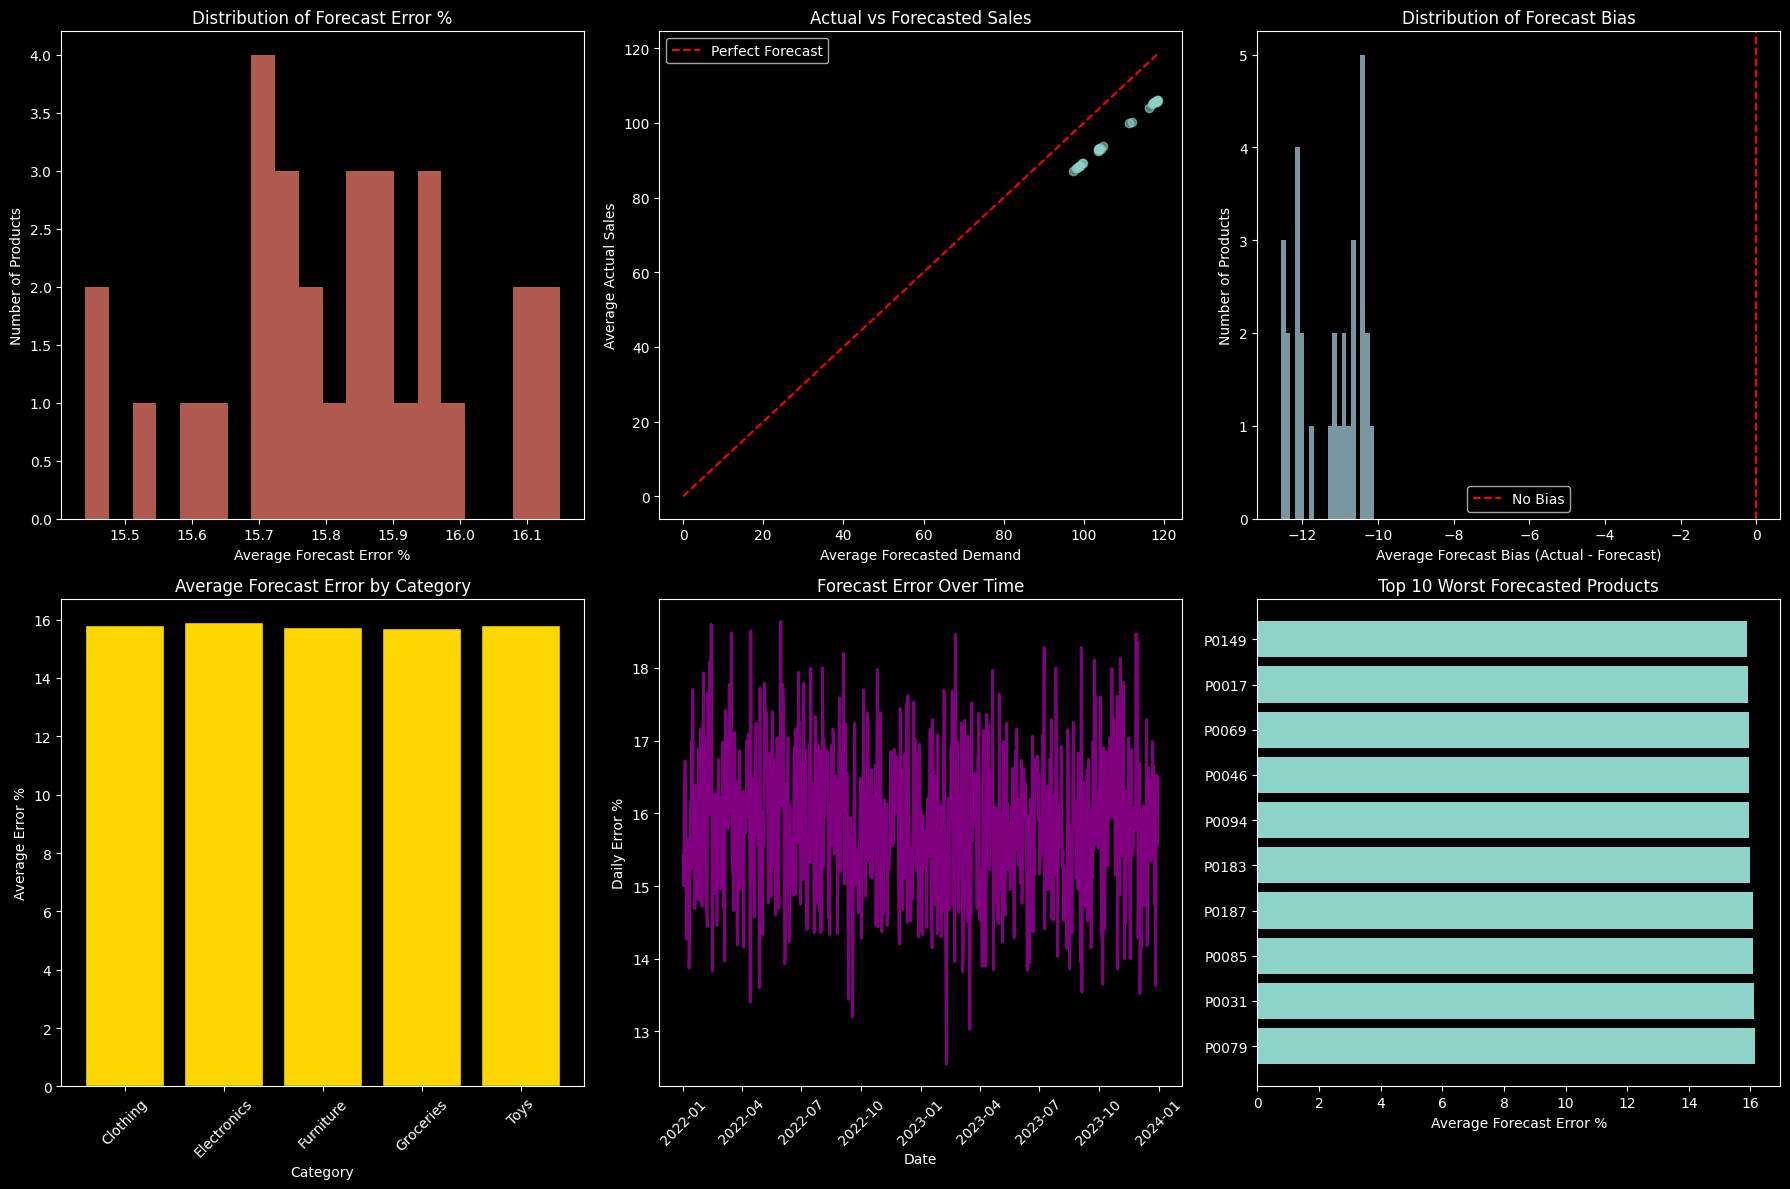

In [26]:
# =====================================
# 5. FORECAST ACCURACY ANALYSIS
# =====================================

# Query 5A: Forecast Accuracy by Product
df_forecast_accuracy = pd.read_sql_query("""
SELECT Product_ID,
       COUNT(*) AS Total_Observations,
       ROUND(AVG(Units_Sold), 2) AS Avg_Actual_Sales,
       ROUND(AVG(Demand_Forecast), 2) AS Avg_Forecasted_Demand,
       ROUND(100 * AVG(ABS(Units_Sold - Demand_Forecast) / NULLIF(Units_Sold, 0)), 2) AS Avg_Forecast_Error_Pct,
       ROUND(AVG(Units_Sold - Demand_Forecast), 2) AS Avg_Forecast_Bias,
       MIN(Date) AS First_Date,
       MAX(Date) AS Last_Date
FROM InventoryData
WHERE Units_Sold > 0
GROUP BY Product_ID
ORDER BY Avg_Forecast_Error_Pct DESC;
""", conn)

# Query 5B: Forecast Accuracy by Store and Category
df_forecast_by_store_category = pd.read_sql_query("""
SELECT Store_ID,
       Category,
       COUNT(*) AS Observations,
       ROUND(AVG(Units_Sold), 2) AS Avg_Actual,
       ROUND(AVG(Demand_Forecast), 2) AS Avg_Forecast,
       ROUND(100 * AVG(ABS(Units_Sold - Demand_Forecast) / NULLIF(Units_Sold, 0)), 2) AS Error_Pct,
       ROUND(AVG(Units_Sold - Demand_Forecast), 2) AS Forecast_Bias
FROM InventoryData
WHERE Units_Sold > 0
GROUP BY Store_ID, Category
ORDER BY Error_Pct DESC;
""", conn)

# Query 5C: Time-based Forecast Performance
df_forecast_by_time = pd.read_sql_query("""
SELECT Date,
       COUNT(*) AS Products_Tracked,
       ROUND(AVG(Units_Sold), 2) AS Daily_Avg_Actual,
       ROUND(AVG(Demand_Forecast), 2) AS Daily_Avg_Forecast,
       ROUND(100 * AVG(ABS(Units_Sold - Demand_Forecast) / NULLIF(Units_Sold, 0)), 2) AS Daily_Error_Pct,
       ROUND(SUM(ABS(Units_Sold - Demand_Forecast)), 2) AS Total_Absolute_Error
FROM InventoryData
WHERE Units_Sold > 0
GROUP BY Date
ORDER BY Date;
""", conn)

print(f"🎯 Forecast Accuracy by Product: {len(df_forecast_accuracy)} products")
print(f"🏪 Forecast by Store & Category: {len(df_forecast_by_store_category)} combinations")
print(f"📅 Daily Forecast Performance: {len(df_forecast_by_time)} days")

# Forecast Accuracy Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: Forecast error distribution
axes[0,0].hist(df_forecast_accuracy['Avg_Forecast_Error_Pct'].dropna(), bins=20, color='salmon', alpha=0.7)
axes[0,0].set_title('Distribution of Forecast Error %')
axes[0,0].set_xlabel('Average Forecast Error %')
axes[0,0].set_ylabel('Number of Products')

# Chart 2: Actual vs Forecasted sales
axes[0,1].scatter(df_forecast_accuracy['Avg_Forecasted_Demand'], 
                  df_forecast_accuracy['Avg_Actual_Sales'], alpha=0.6)
# Add perfect forecast line
max_val = max(df_forecast_accuracy['Avg_Forecasted_Demand'].max(), 
              df_forecast_accuracy['Avg_Actual_Sales'].max())
axes[0,1].plot([0, max_val], [0, max_val], 'r--', label='Perfect Forecast')
axes[0,1].set_title('Actual vs Forecasted Sales')
axes[0,1].set_xlabel('Average Forecasted Demand')
axes[0,1].set_ylabel('Average Actual Sales')
axes[0,1].legend()

# Chart 3: Forecast bias distribution
axes[0,2].hist(df_forecast_accuracy['Avg_Forecast_Bias'].dropna(), bins=20, color='lightblue', alpha=0.7)
axes[0,2].axvline(0, color='red', linestyle='--', label='No Bias')
axes[0,2].set_title('Distribution of Forecast Bias')
axes[0,2].set_xlabel('Average Forecast Bias (Actual - Forecast)')
axes[0,2].set_ylabel('Number of Products')
axes[0,2].legend()

# Chart 4: Forecast accuracy by category
category_accuracy = df_forecast_by_store_category.groupby('Category')['Error_Pct'].mean()
axes[1,0].bar(category_accuracy.index, category_accuracy.values, color='gold', edgecolor='black')
axes[1,0].set_title('Average Forecast Error by Category')
axes[1,0].set_xlabel('Category')
axes[1,0].set_ylabel('Average Error %')
axes[1,0].tick_params(axis='x', rotation=45)

# Chart 5: Forecast performance over time
df_forecast_by_time['Date'] = pd.to_datetime(df_forecast_by_time['Date'])
axes[1,1].plot(df_forecast_by_time['Date'], df_forecast_by_time['Daily_Error_Pct'], 
               color='purple', linewidth=2)
axes[1,1].set_title('Forecast Error Over Time')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Daily Error %')
axes[1,1].tick_params(axis='x', rotation=45)

# Chart 6: Top 10 worst forecasted products
worst_forecast = df_forecast_accuracy.nlargest(10, 'Avg_Forecast_Error_Pct')
axes[1,2].barh(range(len(worst_forecast)), worst_forecast['Avg_Forecast_Error_Pct'])
axes[1,2].set_yticks(range(len(worst_forecast)))
axes[1,2].set_yticklabels(worst_forecast['Product_ID'])
axes[1,2].set_title('Top 10 Worst Forecasted Products')
axes[1,2].set_xlabel('Average Forecast Error %')

plt.tight_layout()
plt.show()

✅ Top 5 Products by Sales Volume: top_products
Products: ['P0057', 'P0046', 'P0133', 'P0187', 'P0125']
✅ ML Forecasting Results: forecast_results
Shape: (70, 4)
📋 Reorder Summary: 5 products
📊 Historical Comparison: 5 products


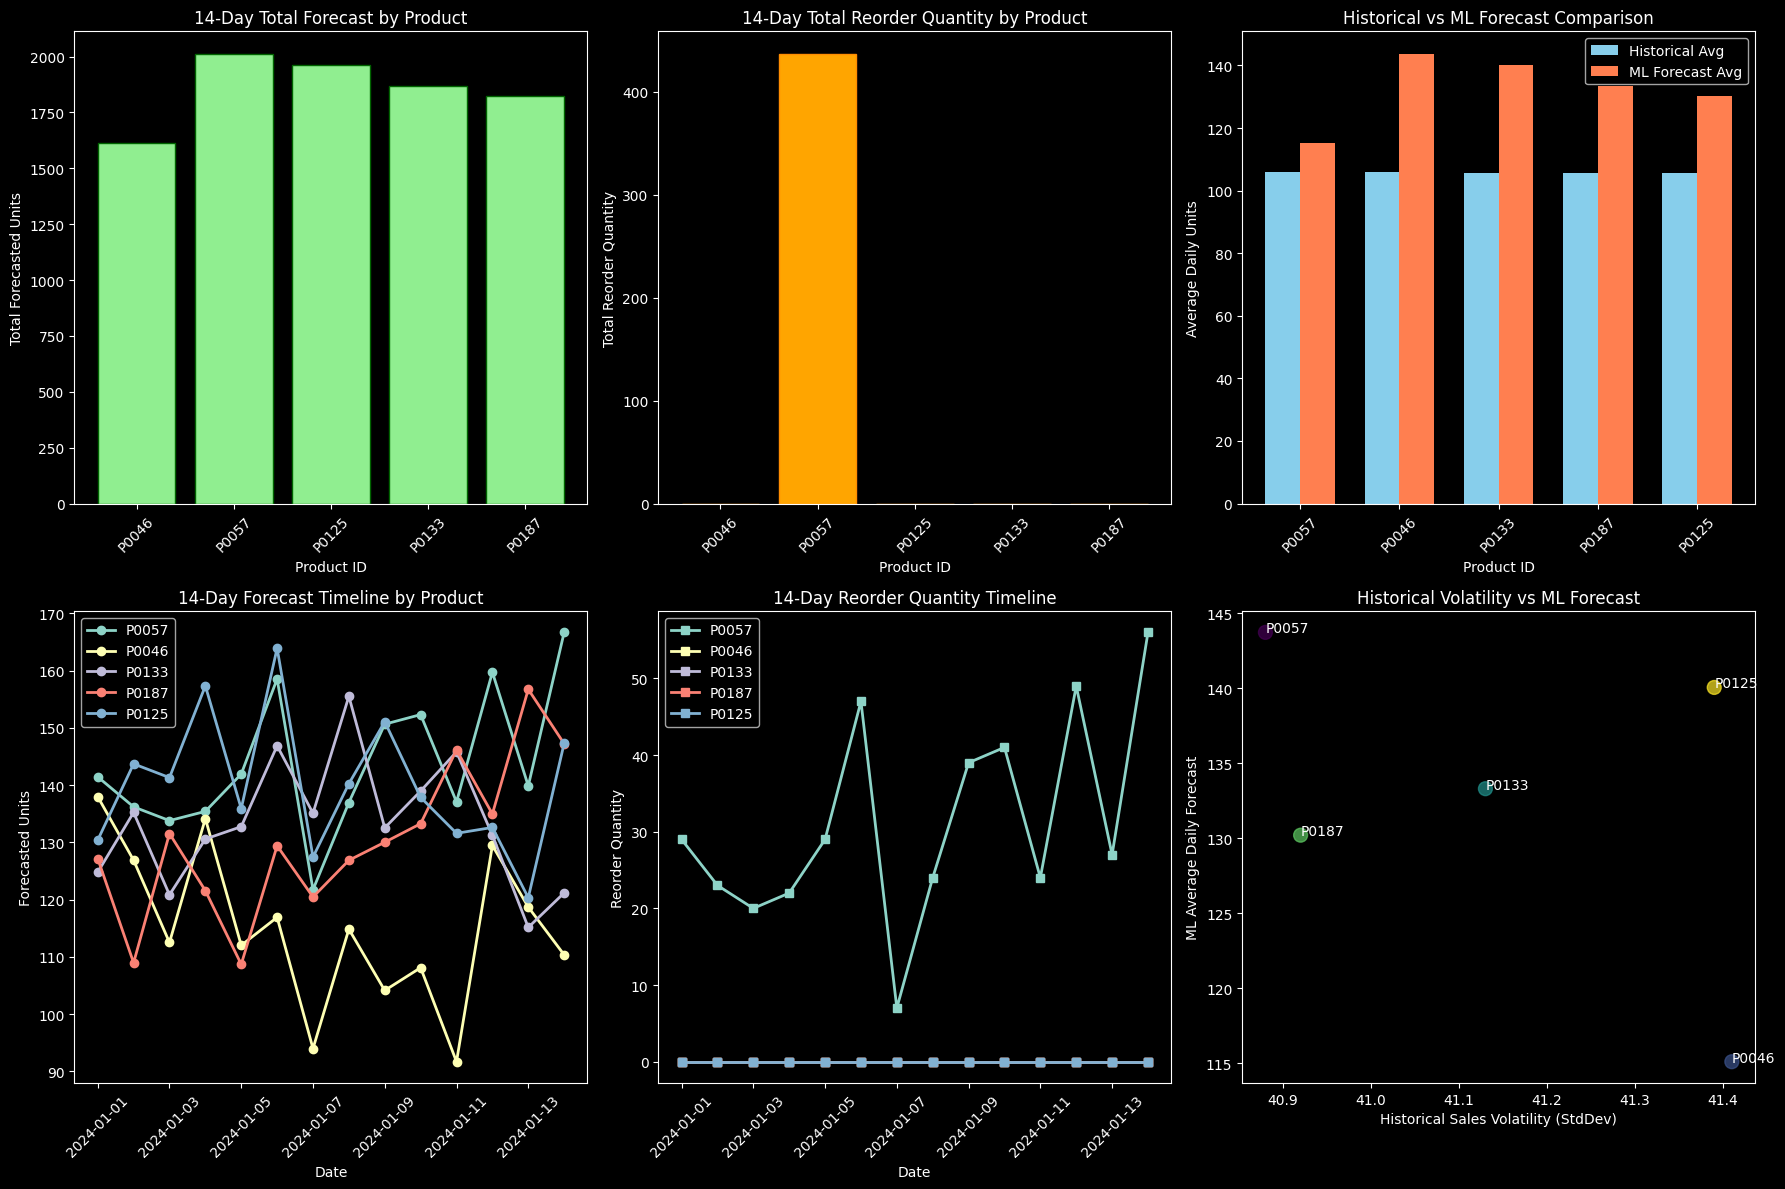

In [27]:
# =====================================
# 6. MACHINE LEARNING FORECASTING RESULTS
# =====================================

# Query 6A: Top Products Analysis (already exists as top_products)
print("✅ Top 5 Products by Sales Volume: top_products")
print(f"Products: {top_products}")

# Query 6B: ML Forecast Results (already exists as forecast_results)
print("✅ ML Forecasting Results: forecast_results")
print(f"Shape: {forecast_results.shape}")

# Query 6C: Reorder Recommendations Summary
df_reorder_summary = forecast_results.groupby('Product_ID').agg({
    'Blended_Forecast': ['sum', 'mean'],
    'Reorder_Qty': ['sum', 'mean', 'max']
}).round(2)

df_reorder_summary.columns = ['Total_Forecast_14Days', 'Avg_Daily_Forecast', 
                              'Total_Reorder_Qty', 'Avg_Daily_Reorder', 'Max_Daily_Reorder']
df_reorder_summary = df_reorder_summary.reset_index()

# Query 6D: Forecast vs Historical Comparison for Top Products
df_forecast_comparison = pd.read_sql_query(f"""
SELECT Product_ID,
       AVG(Units_Sold) AS Historical_Daily_Avg,
       MAX(Units_Sold) AS Historical_Daily_Max,
       MIN(Units_Sold) AS Historical_Daily_Min
FROM InventoryData
WHERE Product_ID IN ({','.join([f"'{p}'" for p in top_products])})
GROUP BY Product_ID
ORDER BY Historical_Daily_Avg DESC;
""", conn)

# Calculate volatility using pandas
volatility_data = pd.read_sql_query(f"""
SELECT Product_ID, Units_Sold 
FROM InventoryData
WHERE Product_ID IN ({','.join([f"'{p}'" for p in top_products])})
""", conn).groupby('Product_ID')['Units_Sold'].std().reset_index()
volatility_data.columns = ['Product_ID', 'Historical_Volatility']
volatility_data['Historical_Volatility'] = volatility_data['Historical_Volatility'].round(2)

# Merge volatility with main dataframe
df_forecast_comparison = df_forecast_comparison.merge(volatility_data, on='Product_ID', how='left')

print(f"📋 Reorder Summary: {len(df_reorder_summary)} products")
print(f"📊 Historical Comparison: {len(df_forecast_comparison)} products")

# ML Forecasting Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: 14-day forecast by product
axes[0,0].bar(df_reorder_summary['Product_ID'], df_reorder_summary['Total_Forecast_14Days'], 
              color='lightgreen', edgecolor='darkgreen')
axes[0,0].set_title('14-Day Total Forecast by Product')
axes[0,0].set_xlabel('Product ID')
axes[0,0].set_ylabel('Total Forecasted Units')
axes[0,0].tick_params(axis='x', rotation=45)

# Chart 2: Reorder quantities by product
axes[0,1].bar(df_reorder_summary['Product_ID'], df_reorder_summary['Total_Reorder_Qty'], 
              color='orange', edgecolor='darkorange')
axes[0,1].set_title('14-Day Total Reorder Quantity by Product')
axes[0,1].set_xlabel('Product ID')
axes[0,1].set_ylabel('Total Reorder Quantity')
axes[0,1].tick_params(axis='x', rotation=45)

# Chart 3: Forecast vs Historical comparison
x_pos = range(len(df_forecast_comparison))
width = 0.35
axes[0,2].bar([x - width/2 for x in x_pos], df_forecast_comparison['Historical_Daily_Avg'], 
              width, label='Historical Avg', color='skyblue')

# Add forecast data
forecast_avgs = df_reorder_summary['Avg_Daily_Forecast']
axes[0,2].bar([x + width/2 for x in x_pos], forecast_avgs, 
              width, label='ML Forecast Avg', color='coral')
axes[0,2].set_title('Historical vs ML Forecast Comparison')
axes[0,2].set_xlabel('Product ID')
axes[0,2].set_ylabel('Average Daily Units')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels(df_forecast_comparison['Product_ID'], rotation=45)
axes[0,2].legend()

# Chart 4: Daily forecast timeline for all products
for i, product in enumerate(top_products):
    product_data = forecast_results[forecast_results['Product_ID'] == product]
    axes[1,0].plot(product_data['Date'], product_data['Blended_Forecast'], 
                   marker='o', label=product, linewidth=2)
axes[1,0].set_title('14-Day Forecast Timeline by Product')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Forecasted Units')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Chart 5: Reorder quantity timeline
for i, product in enumerate(top_products):
    product_data = forecast_results[forecast_results['Product_ID'] == product]
    axes[1,1].plot(product_data['Date'], product_data['Reorder_Qty'], 
                   marker='s', label=product, linewidth=2)
axes[1,1].set_title('14-Day Reorder Quantity Timeline')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Reorder Quantity')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

# Chart 6: Historical volatility vs forecast accuracy proxy
merged_data = df_forecast_comparison.merge(df_reorder_summary, on='Product_ID')
axes[1,2].scatter(merged_data['Historical_Volatility'], merged_data['Avg_Daily_Forecast'], 
                  s=100, alpha=0.7, c=range(len(merged_data)), cmap='viridis')
for i, txt in enumerate(merged_data['Product_ID']):
    axes[1,2].annotate(txt, (merged_data['Historical_Volatility'].iloc[i], 
                            merged_data['Avg_Daily_Forecast'].iloc[i]))
axes[1,2].set_title('Historical Volatility vs ML Forecast')
axes[1,2].set_xlabel('Historical Sales Volatility (StdDev)')
axes[1,2].set_ylabel('ML Average Daily Forecast')

plt.tight_layout()
plt.show()

In [28]:
# =====================================
# 7. COMPREHENSIVE DATAFRAMES SUMMARY
# =====================================

print("📊 COMPREHENSIVE INVENTORY ANALYSIS - ALL DATAFRAMES SUMMARY")
print("="*80)

dataframes_summary = {
    "1. DATA EXPLORATION": {
        "df_distinct_categories": f"Unique product categories ({len(df_distinct_categories)} categories)",
        "df_category_products": f"Category-Product combinations ({len(df_category_products)} combinations)"
    },
    
    "2. KPI ANALYSIS": {
        "df_kpi_by_store": f"Store-level KPIs by category ({df_kpi_by_store.shape[0]} stores)",
        "df_kpi_by_product": f"Product-level KPIs ({df_kpi_by_product.shape[0]} product-store combinations)",
        "df_kpi_anom_2per": f"Products with anomalous order ratios ({len(df_kpi_anom_2per)} anomalies)"
    },
    
    "3. INVENTORY MANAGEMENT": {
        "df_current_stock": f"Current stock levels ({len(df_current_stock)} product-store records)",
        "df_low_inventory_alerts": f"Low inventory alerts ({len(df_low_inventory_alerts)} alerts)",
        "df_rolling_sales_7day": f"7-day rolling sales averages ({len(df_rolling_sales_7day)} products)",
        "df_inventory_turnover": f"Inventory turnover analysis ({len(df_inventory_turnover)} products)",
        "df_avg_daily_sales": f"Daily sales statistics ({len(df_avg_daily_sales)} products)"
    },
    
    "4. PRICING & PROMOTIONS": {
        "df_kpi_by_promotions": f"Promotion impact analysis ({len(df_kpi_by_promotions)} store-category combinations)",
        "df_price_effect": f"Price competitiveness analysis ({len(df_price_effect)} products)",
        "df_price_positioning": f"Price positioning buckets ({len(df_price_positioning)} products)",
        "df_promotion_details": f"Detailed promotion performance ({len(df_promotion_details)} product-store combinations)"
    },
    
    "5. FORECAST ACCURACY": {
        "df_forecast_accuracy": f"Product-level forecast accuracy ({len(df_forecast_accuracy)} products)",
        "df_forecast_by_store_category": f"Forecast accuracy by store & category ({len(df_forecast_by_store_category)} combinations)",
        "df_forecast_by_time": f"Daily forecast performance ({len(df_forecast_by_time)} days)"
    },
    
    "6. MACHINE LEARNING": {
        "top_products": f"Top 5 products by sales volume: {top_products}",
        "forecast_results": f"14-day ML forecasts ({forecast_results.shape[0]} predictions)",
        "df_reorder_summary": f"Reorder recommendations summary ({len(df_reorder_summary)} products)",
        "df_forecast_comparison": f"ML vs historical comparison ({len(df_forecast_comparison)} products)"
    }
}

for section, dataframes in dataframes_summary.items():
    print(f"\n{section}:")
    print("-" * 40)
    for df_name, description in dataframes.items():
        print(f"✅ {df_name}: {description}")

print("\n" + "="*80)
print("🎯 KEY BUSINESS INSIGHTS SUMMARY:")
print("="*80)

# Calculate key insights
total_products = len(df_category_products)
total_categories = len(df_distinct_categories)
avg_forecast_error = df_forecast_accuracy['Avg_Forecast_Error_Pct'].mean()
products_above_competitor_price = len(df_price_positioning[df_price_positioning['Avg_Price_Ratio'] > 1.0])
low_inventory_alerts_count = len(df_low_inventory_alerts)

insights = [
    f"📦 Total Products Analyzed: {total_products} across {total_categories} categories",
    f"🎯 Average Forecast Accuracy: {100 - avg_forecast_error:.1f}% (Error: {avg_forecast_error:.1f}%)",
    f"💰 Products Priced Above Competitors: {products_above_competitor_price}/{len(df_price_positioning)} ({100*products_above_competitor_price/len(df_price_positioning):.1f}%)",
    f"🚨 Active Low Inventory Alerts: {low_inventory_alerts_count} alerts requiring attention",
    f"🔄 Highest Inventory Turnover: {df_inventory_turnover.iloc[0]['Product_ID']} ({df_inventory_turnover.iloc[0]['Inventory_Turnover']:.2f}x)",
    f"📈 Best Performing Category (Promotions): {df_kpi_by_promotions.loc[df_kpi_by_promotions['Percentage_Change_Between_Promotions'].idxmax(), 'Category']}",
    f"🤖 ML Forecasting: Generated 14-day forecasts for top {len(top_products)} products with reorder recommendations"
]

for insight in insights:
    print(insight)

print("\n" + "="*80)
print("✅ ALL QUERIES SUCCESSFULLY SAVED IN NAMED DATAFRAMES WITH VISUALIZATIONS!")
print("="*80)

📊 COMPREHENSIVE INVENTORY ANALYSIS - ALL DATAFRAMES SUMMARY

1. DATA EXPLORATION:
----------------------------------------
✅ df_distinct_categories: Unique product categories (5 categories)
✅ df_category_products: Category-Product combinations (30 combinations)

2. KPI ANALYSIS:
----------------------------------------
✅ df_kpi_by_store: Store-level KPIs by category (5 stores)
✅ df_kpi_by_product: Product-level KPIs (150 product-store combinations)
✅ df_kpi_anom_2per: Products with anomalous order ratios (0 anomalies)

3. INVENTORY MANAGEMENT:
----------------------------------------
✅ df_current_stock: Current stock levels (150 product-store records)
✅ df_low_inventory_alerts: Low inventory alerts (16272 alerts)
✅ df_rolling_sales_7day: 7-day rolling sales averages (30 products)
✅ df_inventory_turnover: Inventory turnover analysis (30 products)
✅ df_avg_daily_sales: Daily sales statistics (30 products)

4. PRICING & PROMOTIONS:
----------------------------------------
✅ df_kpi_by_prom